In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from keras.datasets import fashion_mnist

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

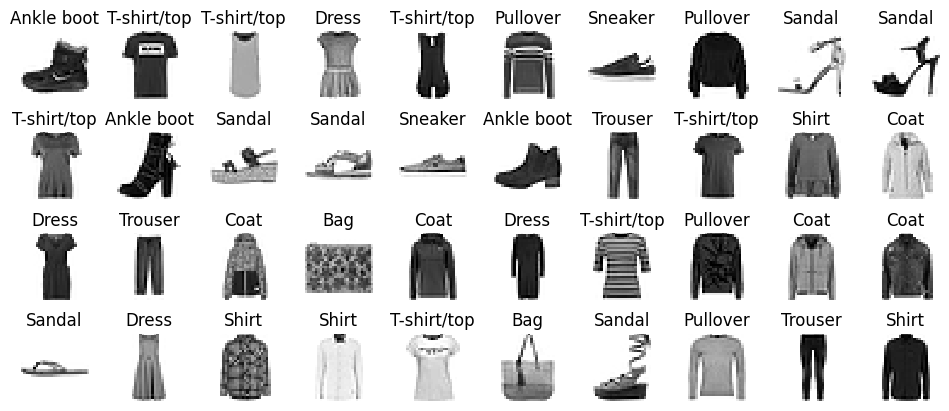

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]]) 
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [12]:
X_train, X_valid, X_test = X_train.reshape(-1, 784), X_valid.reshape(-1, 784), X_test.reshape(-1, 784)
X_train.shape, X_test.shape, X_valid.shape

((55000, 784), (10000, 784), (5000, 784))

In [14]:
# Original model
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=(784,)))
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=30, verbose=0,
                validation_data=(X_valid, y_valid))
_, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy over completely labelled data: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8719 - loss: 0.3733
Test Accuracy over completely labelled data: 0.8733000159263611


In [15]:
def SSL(K):
    kmeans = KMeans(K)
    kmeans.fit(X_train)
    cc = kmeans.cluster_centers_
    
    labelDict = dict([(i,None) for i in range(K)])
    for i in range(K):
        dist = np.linalg.norm(X_train - cc[i], axis=1)
        corLabel = y_train[np.argmin(dist)]
        labelDict[i] = corLabel
    
    propLabels = np.array([labelDict[i] for i in kmeans.predict(X_train)])

    tf.random.set_seed(42)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(784,)))
    model.add(tf.keras.layers.Dense(300, activation="relu"))
    model.add(tf.keras.layers.Dense(100, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="sgd", metrics=["accuracy"])
    
    model.fit(X_train, propLabels, epochs=30, verbose=0,
                    validation_data=(X_valid, y_valid))
    _, test_acc = model.evaluate(X_test, y_test)
    return test_acc

In [16]:
test_accs = []
for K in [10,20,30,40,50,60,70,80,90,100]:
    test_accs.append(SSL(K))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4640 - loss: 11.7640
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5424 - loss: 7.4391
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6057 - loss: 4.5103
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6189 - loss: 3.9398
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6400 - loss: 3.8461
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6434 - loss: 3.4324
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6791 - loss: 2.5963
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6945 - loss: 1.9673
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7015 - loss: 1.8772
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6936 - loss: 1.8309


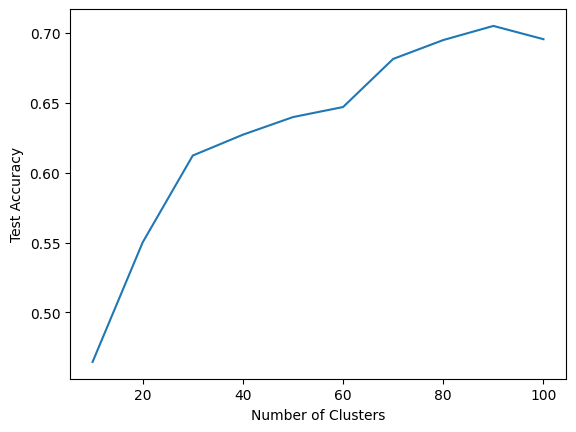

In [17]:
plt.plot([10,20,30,40,50,60,70,80,90,100],test_accs)
plt.xlabel("Number of Clusters")
plt.ylabel("Test Accuracy")
plt.show()